Checking the following quantity for cosmic muon metrics:

$\pi - \Delta\phi_{0,1} + |\eta_0+\eta_1|$

In [3]:
from coffea import hist
import coffea.processor as processor
from coffea.analysis_objects import JaggedCandidateArray
import numpy as np
import matplotlib.pyplot as plt
import awkward

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json

dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

In [57]:
class againstcosmicsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        linearity_axis = hist.Bin('linearity', 'linearity', 50, 0, 1)
        self._accumulator = processor.dict_accumulator({
            'dsainlj': hist.Hist('Counts', dataset_axis, linearity_axis),
            'dsaall': hist.Hist('Counts', dataset_axis, linearity_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        ljcands = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_pfcands_n'].flatten(),
            pt=awkward.fromiter(df['pfjet_pfcand_pt']).flatten().content,
            eta=awkward.fromiter(df['pfjet_pfcand_eta']).flatten().content,
            phi=awkward.fromiter(df['pfjet_pfcand_phi']).flatten().content,
            energy=awkward.fromiter(df['pfjet_pfcand_energy']).flatten().content,
            pfid=awkward.fromiter(df['pfjet_pfcand_type']).flatten().content,
        )

        dsamuinlj = ljcands[ljcands.pfid==8]
        dsamuinljpair = dsamuinlj.distincts()
        val = np.pi \
                -dsamuinljpair.i0.p4.delta_phi(dsamuinljpair.i1.p4)\
                +np.abs(dsamuinljpair.i0.eta+dsamuinljpair.i1.eta)
        output['dsainlj'].fill(dataset=dataset, linearity=val.flatten())
        
        dsamuons = JaggedCandidateArray.candidatesfromcounts(
            df['dsamuon_p4'],
            px=df['dsamuon_p4.fCoordinates.fX'].content,
            py=df['dsamuon_p4.fCoordinates.fY'].content,
            pz=df['dsamuon_p4.fCoordinates.fZ'].content,
            energy=df['dsamuon_p4.fCoordinates.fT'].content,
            nsta=df['dsamuon_nStaValHits'].content,
            normchi2=df['dsamuon_normChi2'].content,
        )
        dsamuons = dsamuons[(dsamuons.pt>20)&(np.abs(dsamuons.eta)<2.4)&(dsamuons.nsta>1)&(dsamuons.normchi2<10)]
        dsamuonpair = dsamuons.distincts(nested=True)
        val = np.pi \
                -dsamuonpair.i0.p4.delta_phi(dsamuonpair.i1.p4)\
                +np.abs(dsamuonpair.i0.eta+dsamuonpair.i1.eta)
        output['dsaall'].fill(dataset=dataset, linearity=val.min().flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

- lxy: 0.3cm

In [58]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=againstcosmicsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:04<00:00,  1.82items/s]


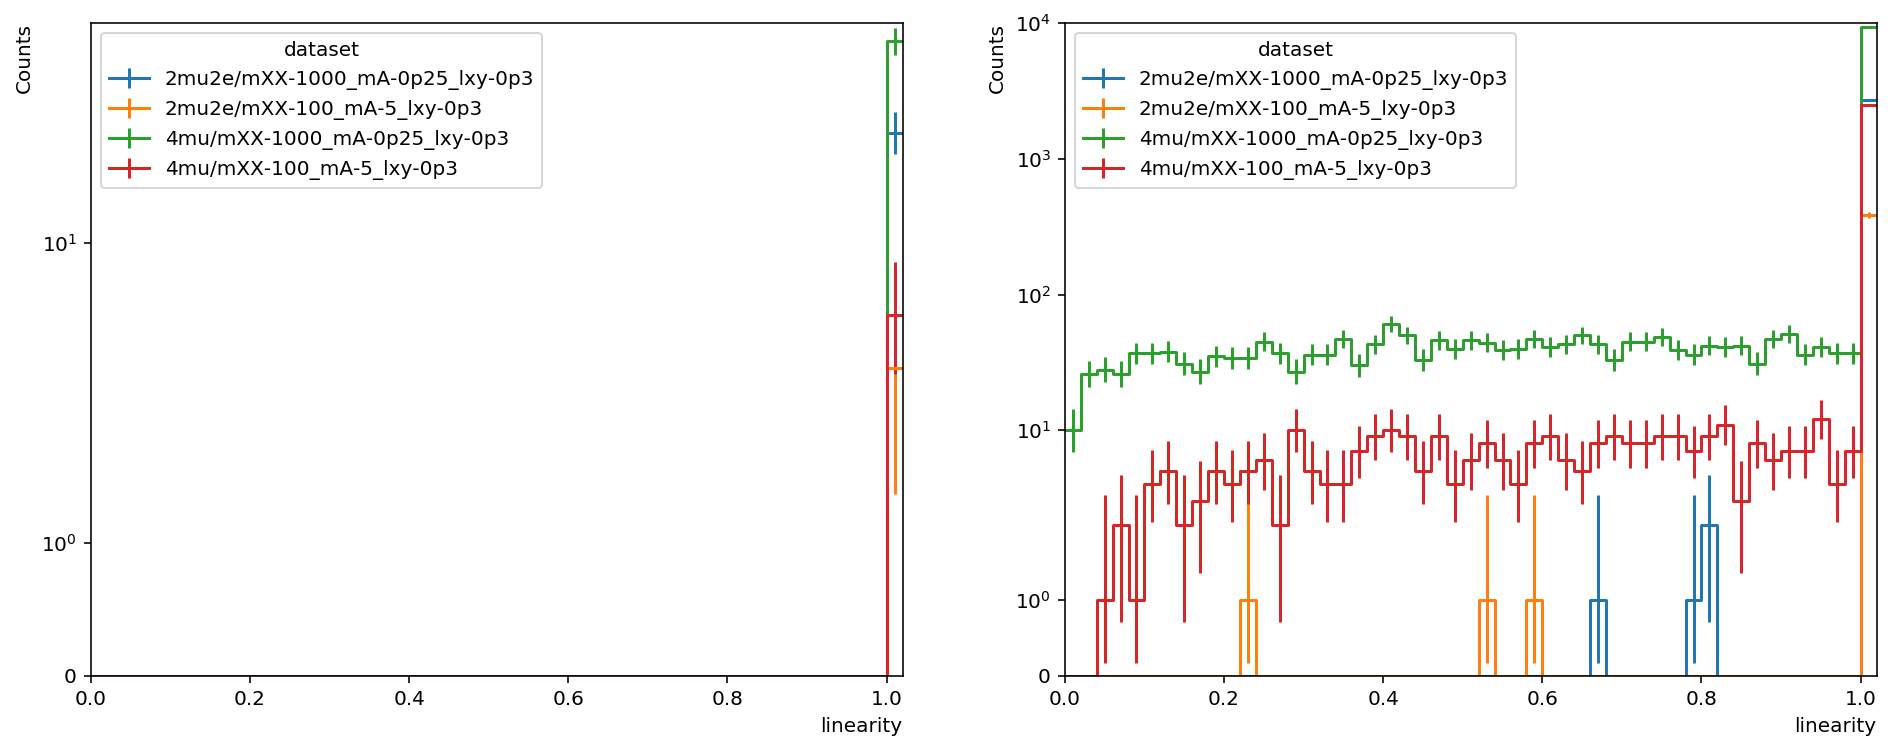

In [59]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['dsainlj'], overlay='dataset', overflow='over', ax=axes[0])
hist.plot1d(output['dsaall'], overlay='dataset', overflow='over', ax=axes[1])
for ax in axes.flat:
    ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

- lxy: 300cm

In [60]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=againstcosmicsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:06<00:00,  3.33items/s]


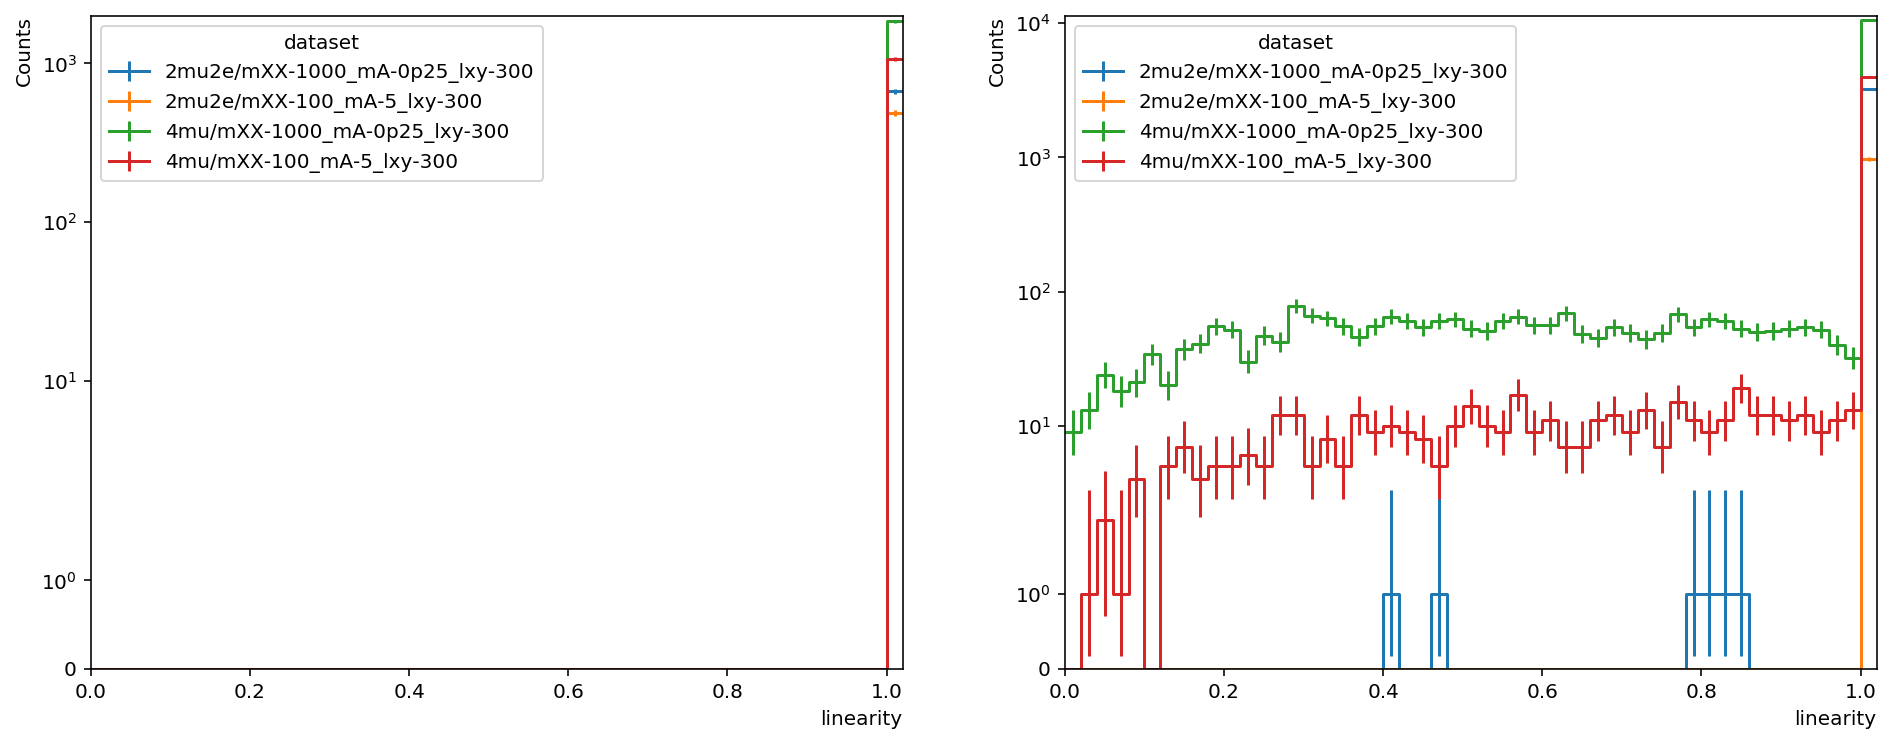

In [61]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['dsainlj'], overlay='dataset', overflow='over', ax=axes[0])
hist.plot1d(output['dsaall'], overlay='dataset', overflow='over', ax=axes[1])
for ax in axes.flat:
    ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")